# GPU Price Analysis

This notebook analyzes GPU pricing data from the database and generates summary statistics.


In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

# Set display options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


## Load Data from Database


In [2]:
# Connect to database
db_path = 'data/gpu_prices.db'
conn = sqlite3.connect(db_path)

# Load all GPU prices
query = """
SELECT 
    timestamp,
    provider,
    instance_type,
    gpu_type,
    gpu_count,
    gpu_memory_gb,
    vcpus,
    ram_gb,
    region,
    price_per_hour,
    is_spot,
    available,
    availability_zone
FROM gpu_prices
ORDER BY timestamp DESC
"""

df = pd.read_sql_query(query, conn)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['price_per_gpu'] = df['price_per_hour'] / df['gpu_count'].replace(0, 1)
# Handle is_spot column - may not exist in old databases
if 'is_spot' not in df.columns:
    df['is_spot'] = False

print(f"Total records: {len(df):,}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Spot instances: {df['is_spot'].sum():,} ({df['is_spot'].sum()/len(df)*100:.1f}%)")
print(f"On-demand instances: {(~df['is_spot']).sum():,} ({(~df['is_spot']).sum()/len(df)*100:.1f}%)")
df.head()


Total records: 782,853
Date range: 2025-10-10 13:58:41.702814 to 2025-12-05 13:54:31.806579
Spot instances: 3,280 (0.4%)
On-demand instances: -786,133 (-100.4%)


,timestamp,provider,instance_type,gpu_type,gpu_count,gpu_memory_gb,vcpus,ram_gb,region,price_per_hour,is_spot,available,availability_zone,price_per_gpu
0,2025-12-05 13:54:31.806579,gcp,a3-highgpu-8g,H100,8,80.0,208,1872.0,asia-northeast1-b,126.643391,0,1.0,None,15.830424
1,2025-12-05 13:54:31.806579,gcp,a3-edgegpu-8g-nolssd,H100,8,80.0,208,1872.0,asia-northeast1-b,125.788596,0,1.0,None,15.723574
2,2025-12-05 13:54:31.806579,gcp,a3-edgegpu-8g,H100,8,80.0,208,1872.0,asia-northeast1-b,125.788596,0,1.0,None,15.723574
3,2025-12-05 13:54:31.806579,gcp,a3-megagpu-8g,H100,8,80.0,208,1872.0,asia-southeast1-b,121.289434,0,1.0,None,15.161179
4,2025-12-05 13:54:31.806579,gcp,a3-megagpu-8g,H100,8,80.0,208,1872.0,asia-southeast1-c,121.289434,0,1.0,None,15.161179


## Database Overview


In [3]:
print("DATABASE SUMMARY")
print("=" * 60)
print(f"Total Records: {len(df):,}")
print(f"Unique Timestamps: {df['timestamp'].nunique()}")
print(f"Providers: {df['provider'].nunique()}")
print(f"GPU Types: {df['gpu_type'].nunique()}")
print(f"Regions: {df['region'].nunique()}")
print(f"Instance Types: {df['instance_type'].nunique()}")
print(f"\nDate Range: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")
print(f"Duration: {(df['timestamp'].max() - df['timestamp'].min()).days} days")


DATABASE SUMMARY
Total Records: 782,853
Unique Timestamps: 32


Providers: 13
GPU Types: 73
Regions: 545
Instance Types: 2137

Date Range: 2025-10-10 to 2025-12-05
Duration: 55 days


## Provider Summary


In [4]:
latest_df = df[df['timestamp'] == df['timestamp'].max()].copy()

provider_stats = latest_df.groupby('provider').agg({
    'instance_type': 'count',
    'price_per_hour': ['min', 'max', 'mean'],
    'price_per_gpu': ['min', 'max', 'mean'],
    'gpu_type': 'nunique',
    'region': 'nunique'
}).round(2)

provider_stats.columns = ['Instances', 'Min $/hr', 'Max $/hr', 'Avg $/hr', 
                          'Min $/GPU', 'Max $/GPU', 'Avg $/GPU', 'GPU Types', 'Regions']
provider_stats = provider_stats.sort_values('Instances', ascending=False)

print("PROVIDER SUMMARY")
print("=" * 80)
provider_stats


PROVIDER SUMMARY


,Instances,Min $/hr,Max $/hr,Avg $/hr,Min $/GPU,Max $/GPU,Avg $/GPU,GPU Types,Regions
provider,,,,,,,,,
gcp,14665,0.05,126.64,4.43,0.05,39.12,3.27,18,127
azure,3167,0.10,65.54,3.47,0.10,20.05,2.63,5,68
aws,2841,0.01,92.47,3.91,0.01,20.26,2.70,8,103
vultr,2810,0.00,22.40,0.55,0.00,5.26,0.53,5,32
oci,1134,0.06,32.00,7.11,0.06,13.82,3.34,6,42
lambdalabs,357,0.50,39.92,7.23,0.50,5.29,2.12,8,17
datacrunch,208,0.03,39.60,5.54,0.03,4.95,1.59,11,4
runpod,111,0.16,41.52,7.07,0.13,5.19,1.28,30,38
vastai,64,0.05,9.48,0.88,0.04,2.37,0.41,17,34


## GPU Type Summary


In [5]:
gpu_df = latest_df[latest_df['gpu_type'] != 'Unknown'].copy()

gpu_stats = gpu_df.groupby('gpu_type').agg({
    'instance_type': 'count',
    'price_per_gpu': ['min', 'max', 'mean', 'median'],
    'provider': lambda x: x.nunique(),
    'gpu_count': 'sum'
}).round(2)

gpu_stats.columns = ['Instances', 'Min $/GPU', 'Max $/GPU', 'Avg $/GPU', 'Median $/GPU', 'Providers', 'Total GPUs']
gpu_stats = gpu_stats.sort_values('Instances', ascending=False)

print("GPU TYPE SUMMARY (Top 20)")
print("=" * 90)
gpu_stats.head(20)


GPU TYPE SUMMARY (Top 20)


,Instances,Min $/GPU,Max $/GPU,Avg $/GPU,Median $/GPU,Providers,Total GPUs
gpu_type,,,,,,,
T4,1209,0.34,7.40,1.09,0.90,3,4052
V100,588,0.14,6.12,2.84,2.95,8,3347
L4,534,0.39,5.77,1.51,1.23,3,1259
A100,481,0.12,8.19,3.13,3.05,9,2376
A10,365,0.45,9.04,2.56,2.00,3,570
H100,305,0.60,15.83,4.98,3.09,8,1394
P100,204,1.27,3.61,1.73,1.63,2,606
L40S,138,0.86,10.99,3.31,3.50,5,426
A10G,130,1.01,6.96,2.42,2.09,1,338


## Spot Price Analysis


In [6]:
# Analyze spot vs on-demand pricing
latest_df = df[df['timestamp'] == df['timestamp'].max()].copy()

# Compare spot vs on-demand prices by GPU type
gpu_spot_analysis = latest_df.groupby(['gpu_type', 'is_spot']).agg({
    'price_per_gpu': ['mean', 'min', 'max', 'count'],
    'instance_type': 'nunique'
}).round(2)

# Pivot to show spot vs on-demand side by side
spot_vs_ondemand = latest_df.pivot_table(
    index='gpu_type',
    columns='is_spot',
    values='price_per_gpu',
    aggfunc='mean'
).round(2)
spot_vs_ondemand.columns = ['On-Demand', 'Spot']
spot_vs_ondemand['Savings %'] = ((spot_vs_ondemand['On-Demand'] - spot_vs_ondemand['Spot']) / spot_vs_ondemand['On-Demand'] * 100).round(1)
spot_vs_ondemand = spot_vs_ondemand.sort_values('On-Demand', ascending=False)

print("SPOT vs ON-DEMAND PRICE COMPARISON (Top 20 GPU Types)")
print("=" * 80)
print(spot_vs_ondemand.head(20).to_string())

# Count instances
spot_counts = latest_df.groupby(['gpu_type', 'is_spot']).size().unstack(fill_value=0)
spot_counts.columns = ['On-Demand Count', 'Spot Count']
spot_counts = spot_counts.sort_values('On-Demand Count', ascending=False)

print("\n\nINSTANCE AVAILABILITY: Spot vs On-Demand")
print("=" * 80)
print(spot_counts.head(20).to_string())


SPOT vs ON-DEMAND PRICE COMPARISON (Top 20 GPU Types)
             On-Demand   Spot  Savings %
gpu_type                                
v6e-8            22.41    NaN        NaN
v5p-8            12.77  12.50        2.1
v6e-4            11.20    NaN        NaN
v5litepod-8      10.72    NaN        NaN
v3-8              8.16    NaN        NaN
H100              5.85   2.54       56.6
B200              5.71    NaN        NaN
v5litepod-4       5.36    NaN        NaN
B300              4.95    NaN        NaN
v2-8              4.73    NaN        NaN
RTXPRO6000        3.31    NaN        NaN
L40S              3.31    NaN        NaN
A100              3.12   3.71      -18.9
H200              3.09   1.75       43.4
Unknown           2.87    NaN        NaN
V100              2.84   3.91      -37.7
v6e-1             2.80    NaN        NaN
H100NVL           2.75    NaN        NaN
A10               2.56    NaN        NaN
A10G              2.42   2.77      -14.5


INSTANCE AVAILABILITY: Spot vs On-Demand
 

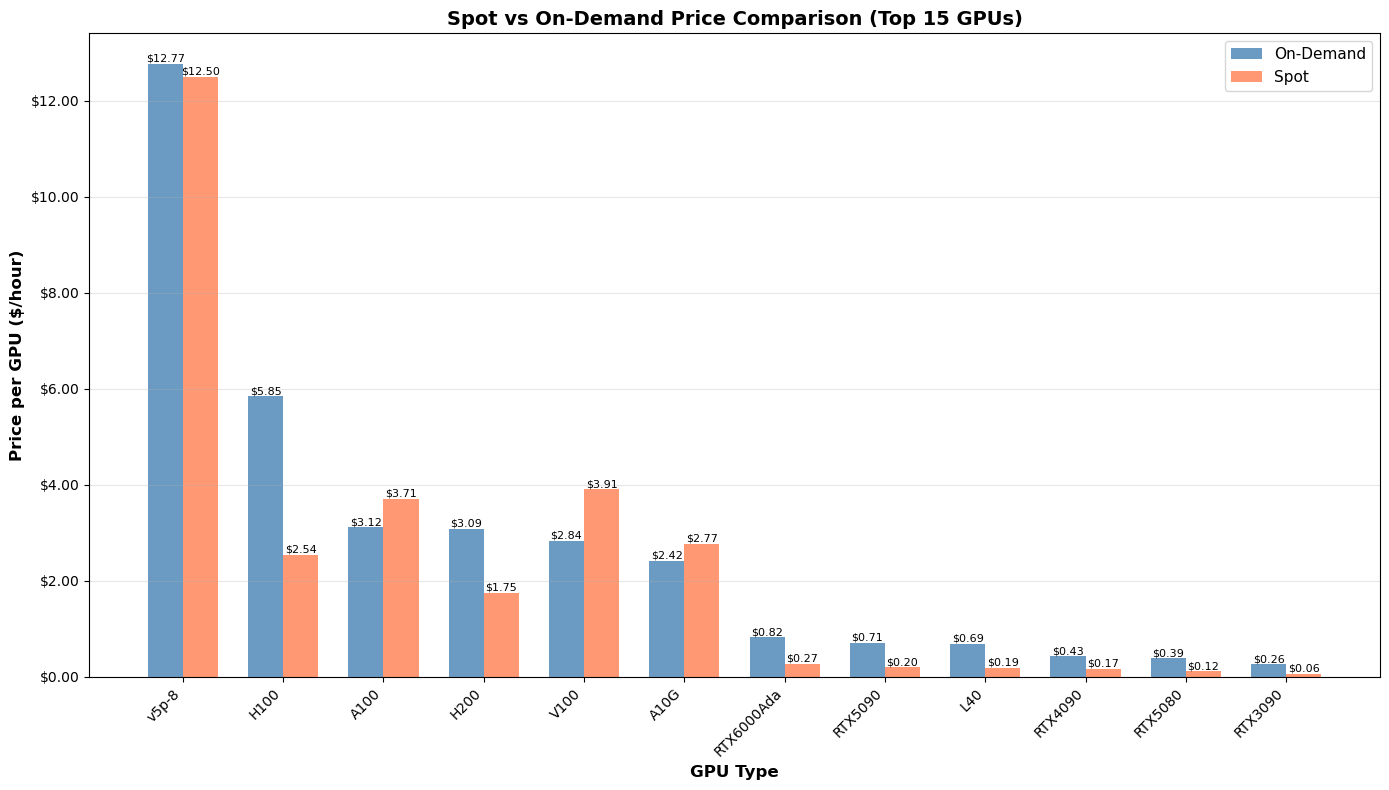

Spot vs on-demand price comparison saved to: reports/figures/spot_vs_ondemand_prices.png


In [7]:
# Spot vs On-Demand Price Comparison - Bar Chart
# Filter to GPUs that have both spot and on-demand prices
gpus_with_both = spot_vs_ondemand.dropna().head(15)

fig, ax = plt.subplots(figsize=(14, 8))
x = range(len(gpus_with_both))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], gpus_with_both['On-Demand'], 
               width, label='On-Demand', color='steelblue', alpha=0.8)
bars2 = ax.bar([i + width/2 for i in x], gpus_with_both['Spot'], 
               width, label='Spot', color='coral', alpha=0.8)

ax.set_xlabel('GPU Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Price per GPU ($/hour)', fontsize=12, fontweight='bold')
ax.set_title('Spot vs On-Demand Price Comparison (Top 15 GPUs)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(gpus_with_both.index, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'${height:.2f}',
                   ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('reports/figures/spot_vs_ondemand_prices.png', dpi=300, bbox_inches='tight')
plt.show()
print("Spot vs on-demand price comparison saved to: reports/figures/spot_vs_ondemand_prices.png")


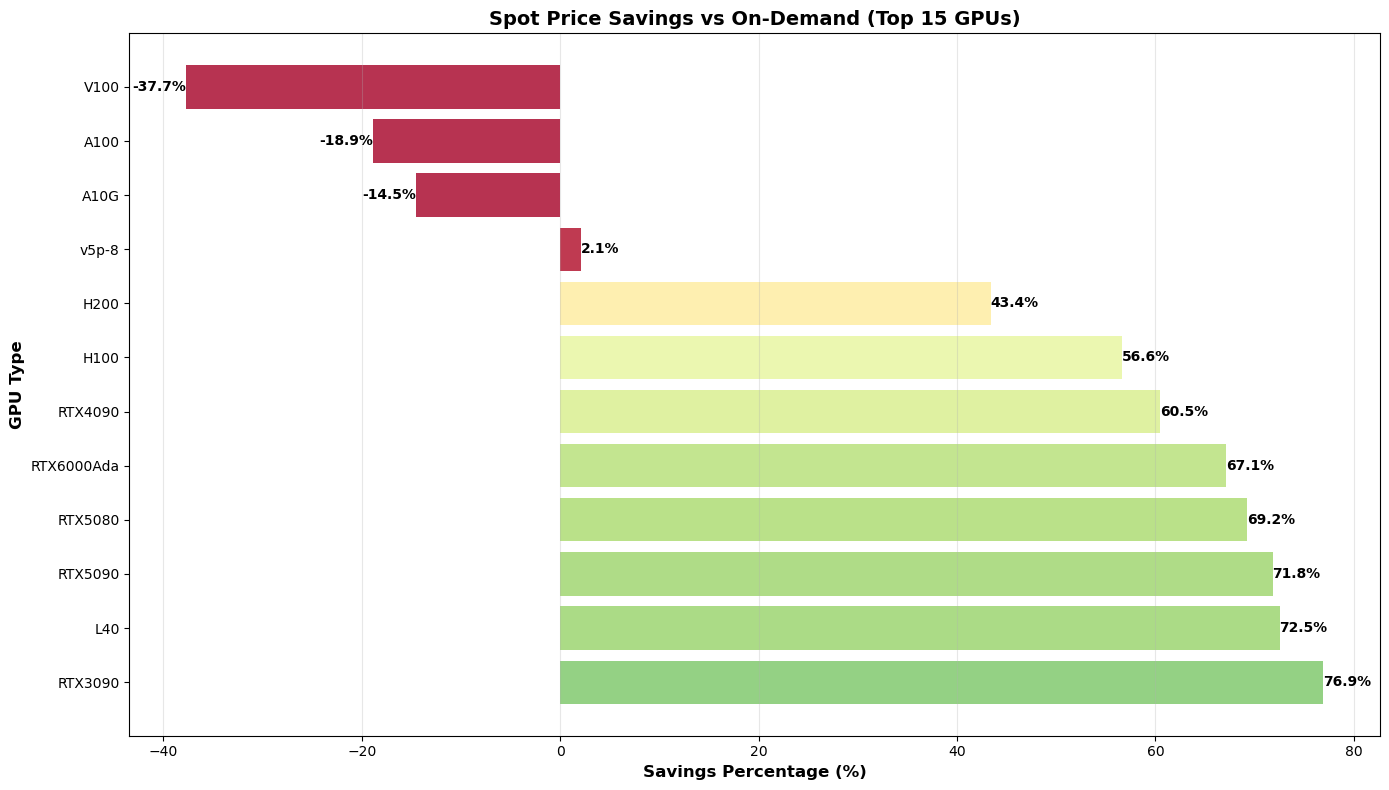

Spot price savings visualization saved to: reports/figures/spot_price_savings.png


In [8]:
# Spot Price Savings Percentage
gpus_with_savings = spot_vs_ondemand[spot_vs_ondemand['Savings %'].notna()].sort_values('Savings %', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.RdYlGn([savings/100 for savings in gpus_with_savings['Savings %']])
bars = ax.barh(gpus_with_savings.index, gpus_with_savings['Savings %'], color=colors, alpha=0.8)

ax.set_xlabel('Savings Percentage (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('GPU Type', fontsize=12, fontweight='bold')
ax.set_title('Spot Price Savings vs On-Demand (Top 15 GPUs)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, savings) in enumerate(gpus_with_savings['Savings %'].items()):
    ax.text(savings, i, f'{savings:.1f}%', 
           va='center', ha='left' if savings > 0 else 'right', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('reports/figures/spot_price_savings.png', dpi=300, bbox_inches='tight')
plt.show()
print("Spot price savings visualization saved to: reports/figures/spot_price_savings.png")


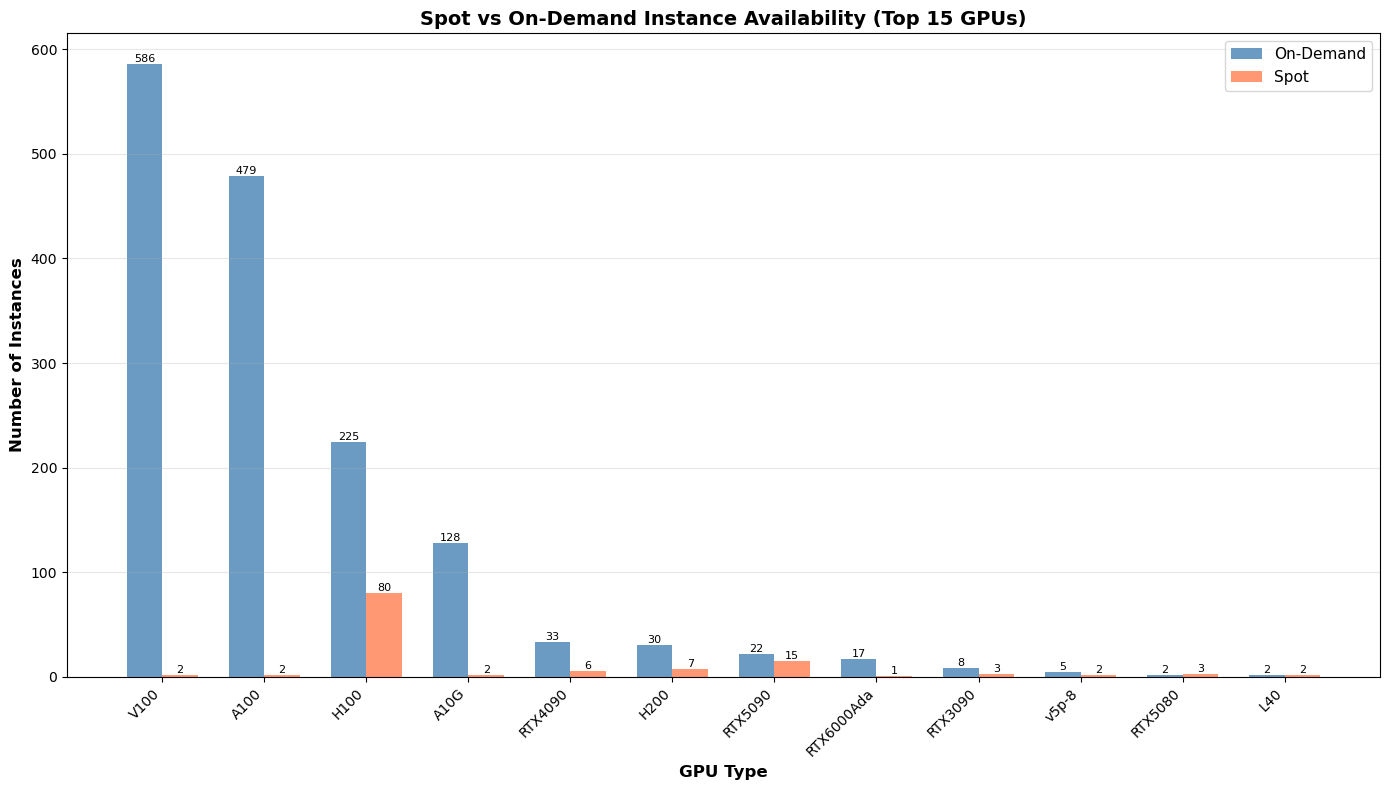

Spot vs on-demand availability comparison saved to: reports/figures/spot_vs_ondemand_availability.png


In [9]:

# Spot vs On-Demand Availability Comparison
gpus_with_both_counts = spot_counts[(spot_counts['On-Demand Count'] > 0) & (spot_counts['Spot Count'] > 0)].head(15)

fig, ax = plt.subplots(figsize=(14, 8))
x = range(len(gpus_with_both_counts))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], gpus_with_both_counts['On-Demand Count'], 
               width, label='On-Demand', color='steelblue', alpha=0.8)
bars2 = ax.bar([i + width/2 for i in x], gpus_with_both_counts['Spot Count'], 
               width, label='Spot', color='coral', alpha=0.8)

ax.set_xlabel('GPU Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Instances', fontsize=12, fontweight='bold')
ax.set_title('Spot vs On-Demand Instance Availability (Top 15 GPUs)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(gpus_with_both_counts.index, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('reports/figures/spot_vs_ondemand_availability.png', dpi=300, bbox_inches='tight')
plt.show()
print("Spot vs on-demand availability comparison saved to: reports/figures/spot_vs_ondemand_availability.png")

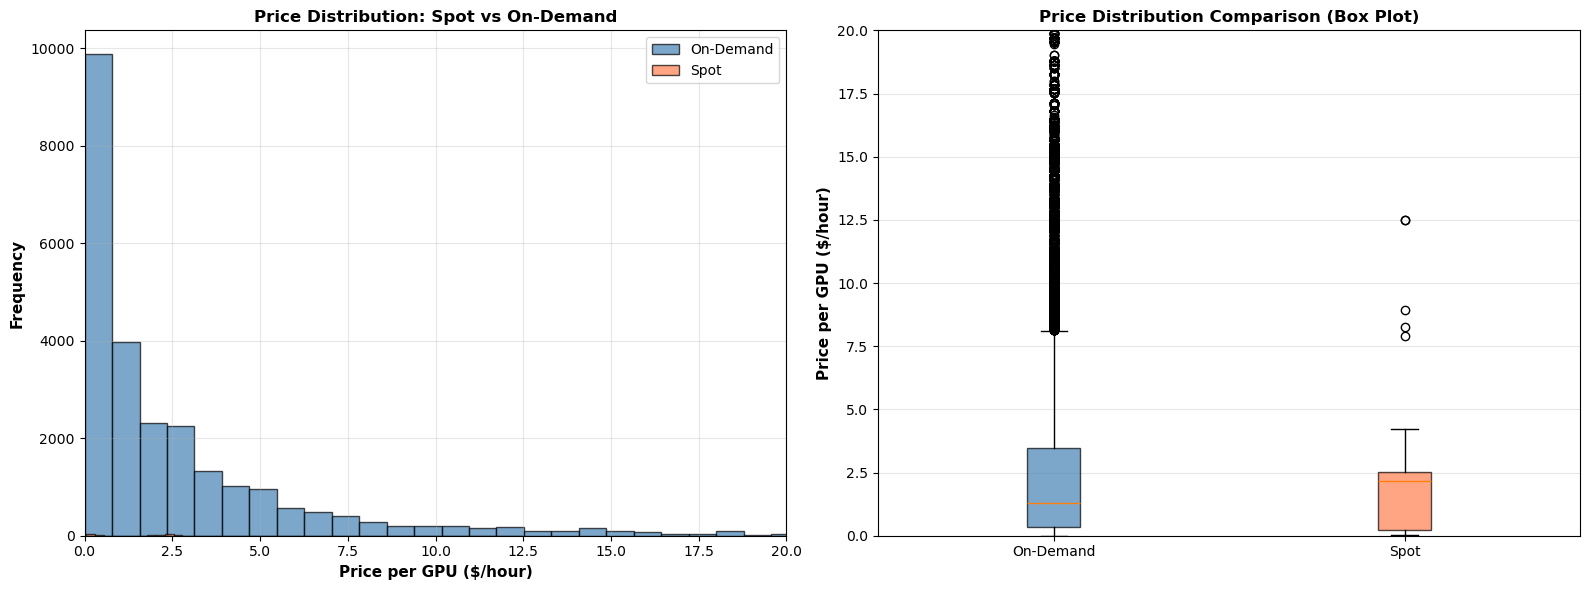

Spot price distribution comparison saved to: reports/figures/spot_price_distribution.png


In [10]:

# Price Distribution Comparison: Spot vs On-Demand
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of prices
spot_prices = latest_df[latest_df['is_spot'] == True]['price_per_gpu']
ondemand_prices = latest_df[latest_df['is_spot'] == False]['price_per_gpu']

axes[0].hist(ondemand_prices, bins=50, alpha=0.7, label='On-Demand', color='steelblue', edgecolor='black')
axes[0].hist(spot_prices, bins=50, alpha=0.7, label='Spot', color='coral', edgecolor='black')
axes[0].set_xlabel('Price per GPU ($/hour)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Price Distribution: Spot vs On-Demand', fontsize=12, fontweight='bold')
axes[0].set_xlim(0, 20)  # Limit to reasonable range
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Box plot comparison
data_to_plot = [ondemand_prices.dropna(), spot_prices.dropna()]
bp = axes[1].boxplot(data_to_plot, labels=['On-Demand', 'Spot'], patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_facecolor('coral')
bp['boxes'][1].set_alpha(0.7)
axes[1].set_ylabel('Price per GPU ($/hour)', fontsize=11, fontweight='bold')
axes[1].set_title('Price Distribution Comparison (Box Plot)', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, 20)  # Limit to reasonable range
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('reports/figures/spot_price_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Spot price distribution comparison saved to: reports/figures/spot_price_distribution.png")

Number of snapshots: 32


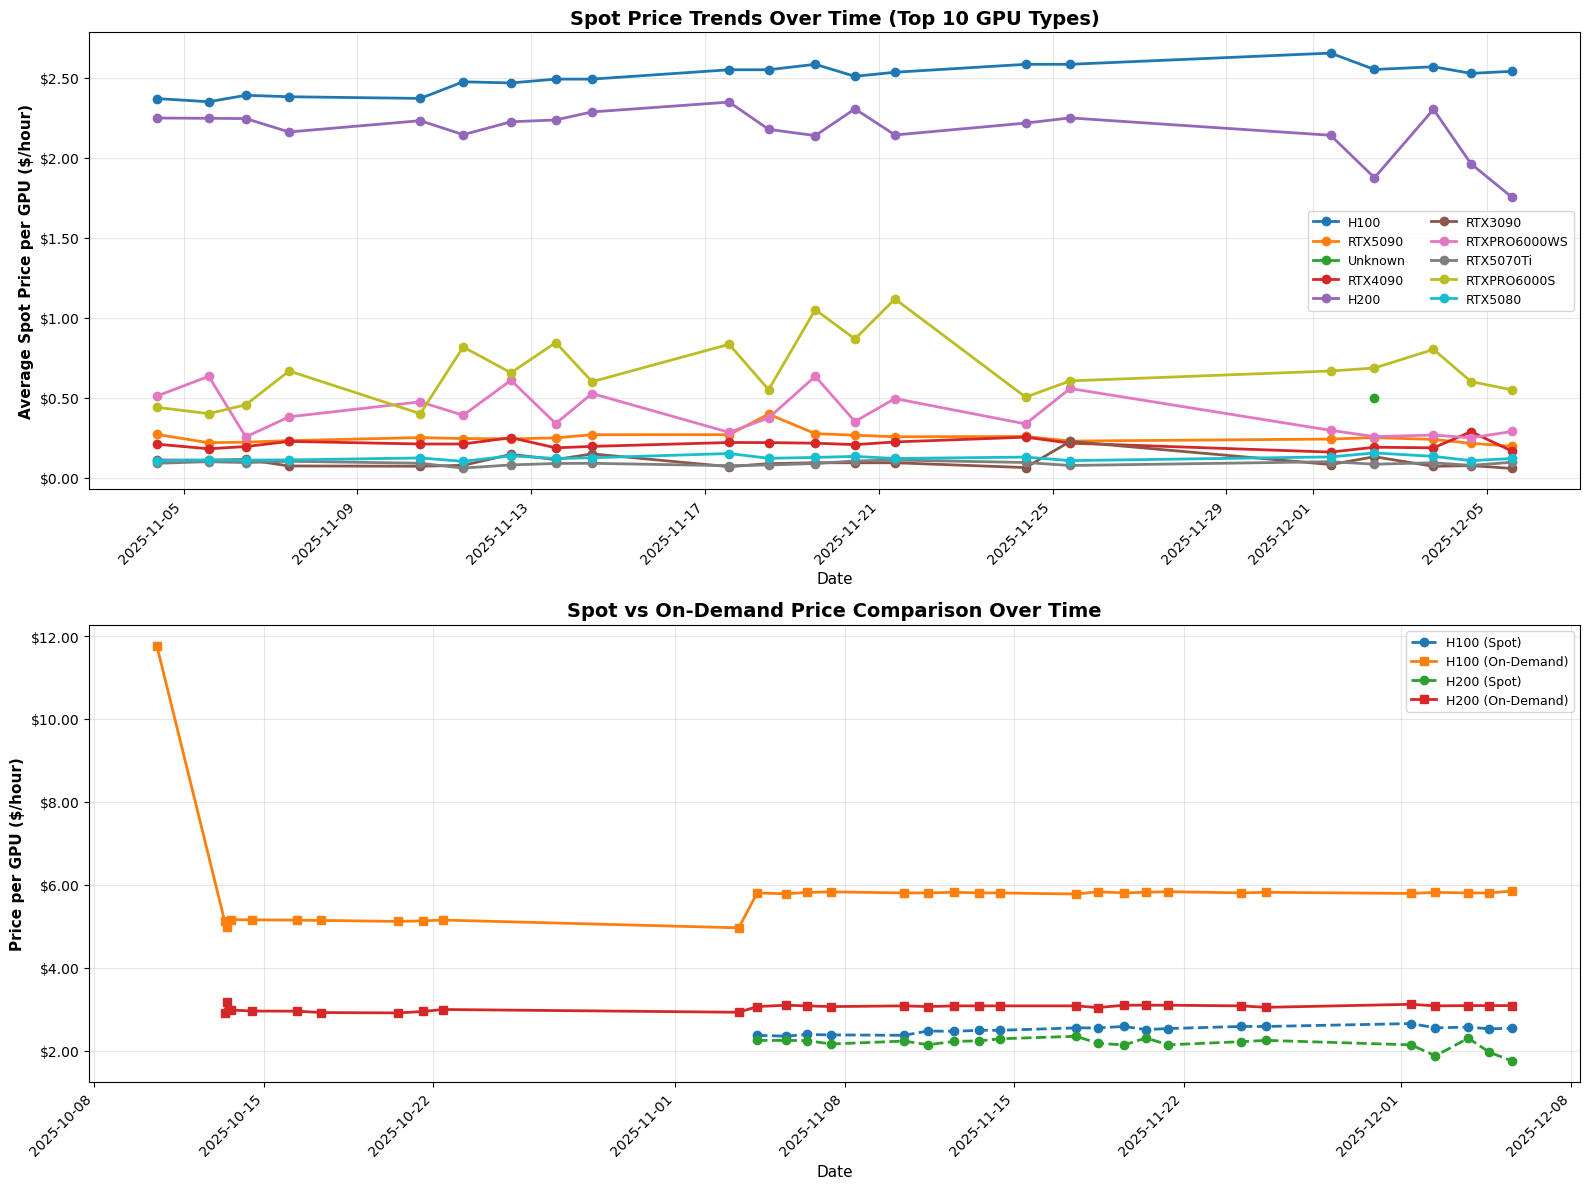

Spot price time series saved to: reports/figures/spot_price_timeseries.png


In [11]:
# Spot Price Time Series (if multiple snapshots)
num_snapshots = df['timestamp'].nunique()
print(f"Number of snapshots: {num_snapshots}")

if num_snapshots > 1 and df['is_spot'].sum() > 0:
    # Get top GPU types that have spot prices
    spot_df = df[df['is_spot'] == True].copy()
    top_spot_gpus = spot_df.groupby('gpu_type').size().nlargest(10).index.tolist()
    
    if top_spot_gpus:
        # Calculate average spot price per GPU for each timestamp and GPU type
        spot_ts = spot_df[spot_df['gpu_type'].isin(top_spot_gpus)].groupby(['timestamp', 'gpu_type'])['price_per_gpu'].mean().reset_index()
        
        # Also get on-demand prices for comparison
        ondemand_df = df[df['is_spot'] == False].copy()
        ondemand_ts = ondemand_df[ondemand_df['gpu_type'].isin(top_spot_gpus)].groupby(['timestamp', 'gpu_type'])['price_per_gpu'].mean().reset_index()
        
        # Create time series plot
        fig, axes = plt.subplots(2, 1, figsize=(16, 12))
        
        # Plot 1: Spot prices over time
        for gpu in top_spot_gpus[:10]:
            gpu_data = spot_ts[spot_ts['gpu_type'] == gpu]
            if len(gpu_data) > 0:
                axes[0].plot(gpu_data['timestamp'], gpu_data['price_per_gpu'], 
                            marker='o', linewidth=2, markersize=6, label=gpu)
        
        axes[0].set_title('Spot Price Trends Over Time (Top 10 GPU Types)', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Date', fontsize=11)
        axes[0].set_ylabel('Average Spot Price per GPU ($/hour)', fontsize=11, fontweight='bold')
        axes[0].legend(loc='best', fontsize=9, ncol=2)
        axes[0].grid(True, alpha=0.3)
        axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))
        plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # Plot 2: Spot vs On-Demand comparison for specific GPUs
        comparison_gpus = ['H100', 'A100', 'B200', 'H200']
        available_gpus = [gpu for gpu in comparison_gpus if gpu in top_spot_gpus][:4]
        
        for gpu in available_gpus:
            spot_data = spot_ts[spot_ts['gpu_type'] == gpu]
            ondemand_data = ondemand_ts[ondemand_ts['gpu_type'] == gpu]
            
            if len(spot_data) > 0:
                axes[1].plot(spot_data['timestamp'], spot_data['price_per_gpu'], 
                            marker='o', linewidth=2, markersize=6, label=f'{gpu} (Spot)', linestyle='--')
            if len(ondemand_data) > 0:
                axes[1].plot(ondemand_data['timestamp'], ondemand_data['price_per_gpu'], 
                            marker='s', linewidth=2, markersize=6, label=f'{gpu} (On-Demand)', linestyle='-')
        
        axes[1].set_title('Spot vs On-Demand Price Comparison Over Time', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Date', fontsize=11)
        axes[1].set_ylabel('Price per GPU ($/hour)', fontsize=11, fontweight='bold')
        axes[1].legend(loc='best', fontsize=9)
        axes[1].grid(True, alpha=0.3)
        axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))
        plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.savefig('reports/figures/spot_price_timeseries.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Spot price time series saved to: reports/figures/spot_price_timeseries.png")
    else:
        print("No spot instances found in historical data.")
else:
    if num_snapshots <= 1:
        print("Need multiple snapshots for spot price time series analysis.")
    else:
        print("No spot instances found in the data.")


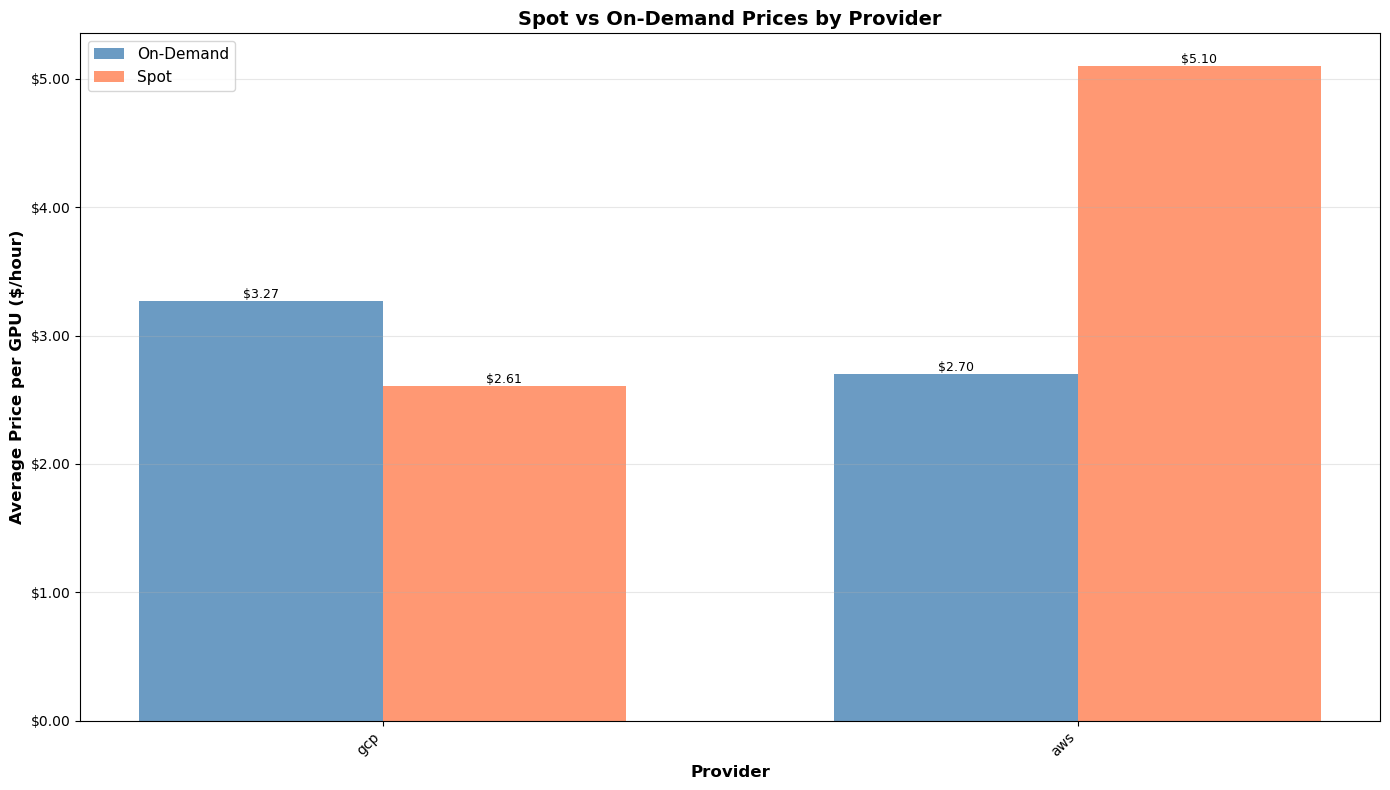

Spot prices by provider saved to: reports/figures/spot_prices_by_provider.png


In [12]:
# Provider-wise Spot Price Analysis
provider_spot = latest_df.groupby(['provider', 'is_spot']).agg({
    'price_per_gpu': 'mean',
    'instance_type': 'count'
}).round(2)

# Create comparison
provider_comparison = latest_df.pivot_table(
    index='provider',
    columns='is_spot',
    values='price_per_gpu',
    aggfunc='mean'
).round(2)
provider_comparison.columns = ['On-Demand', 'Spot']
provider_comparison = provider_comparison.sort_values('On-Demand', ascending=False)

# Only show providers that have both spot and on-demand
providers_with_both = provider_comparison.dropna()

if len(providers_with_both) > 0:
    fig, ax = plt.subplots(figsize=(14, 8))
    x = range(len(providers_with_both))
    width = 0.35
    
    bars1 = ax.bar([i - width/2 for i in x], providers_with_both['On-Demand'], 
                   width, label='On-Demand', color='steelblue', alpha=0.8)
    bars2 = ax.bar([i + width/2 for i in x], providers_with_both['Spot'], 
                   width, label='Spot', color='coral', alpha=0.8)
    
    ax.set_xlabel('Provider', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Price per GPU ($/hour)', fontsize=12, fontweight='bold')
    ax.set_title('Spot vs On-Demand Prices by Provider', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(providers_with_both.index, rotation=45, ha='right')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'${height:.2f}',
                       ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('reports/figures/spot_prices_by_provider.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Spot prices by provider saved to: reports/figures/spot_prices_by_provider.png")
else:
    print("No providers with both spot and on-demand pricing found.")


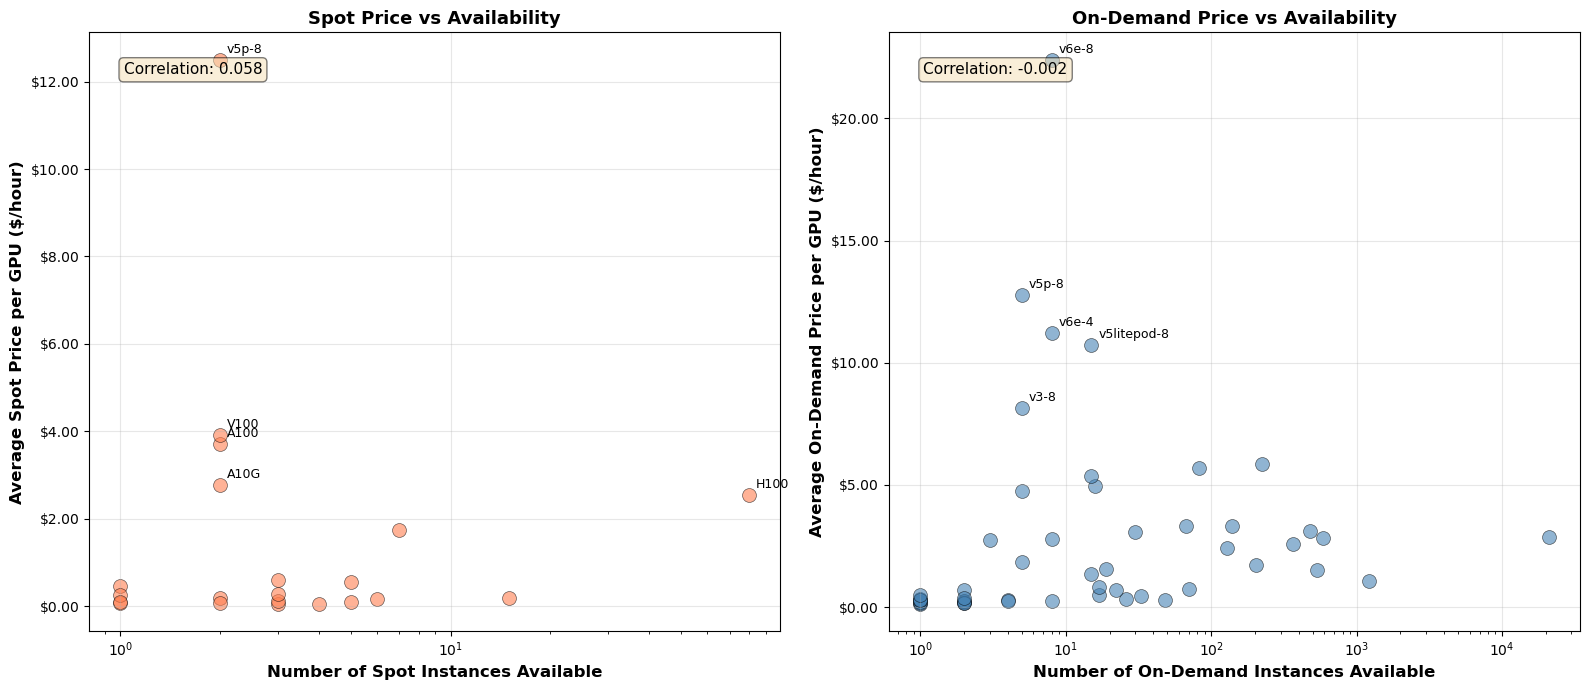

Price vs availability relationship plots saved to: reports/figures/price_vs_availability_relationship.png


In [13]:
# Price vs Availability Relationship: Spot and On-Demand
# Group by GPU type and pricing type to get average price and instance count
price_availability = latest_df.groupby(['gpu_type', 'is_spot']).agg({
    'price_per_gpu': 'mean',
    'instance_type': 'count'
}).reset_index()
price_availability.columns = ['gpu_type', 'is_spot', 'avg_price', 'instance_count']

# Separate spot and on-demand
spot_data = price_availability[price_availability['is_spot'] == True].copy()
ondemand_data = price_availability[price_availability['is_spot'] == False].copy()

# Create scatter plots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Spot instances: Price vs Availability
if len(spot_data) > 0:
    scatter1 = axes[0].scatter(spot_data['instance_count'], spot_data['avg_price'], 
                              s=100, alpha=0.6, color='coral', edgecolors='black', linewidth=0.5)
    axes[0].set_xlabel('Number of Spot Instances Available', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Average Spot Price per GPU ($/hour)', fontsize=12, fontweight='bold')
    axes[0].set_title('Spot Price vs Availability', fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xscale('log')  # Log scale for better visualization if instances vary widely
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))
    
    # Add labels for top GPUs by price
    top_spot = spot_data.nlargest(5, 'avg_price')
    for _, row in top_spot.iterrows():
        axes[0].annotate(row['gpu_type'], 
                        (row['instance_count'], row['avg_price']),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Add correlation coefficient
    if len(spot_data) > 1:
        corr = spot_data['instance_count'].corr(spot_data['avg_price'])
        axes[0].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                    transform=axes[0].transAxes, fontsize=11,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
else:
    axes[0].text(0.5, 0.5, 'No spot instances available', 
                ha='center', va='center', fontsize=12, transform=axes[0].transAxes)
    axes[0].set_title('Spot Price vs Availability', fontsize=13, fontweight='bold')

# On-Demand instances: Price vs Availability
if len(ondemand_data) > 0:
    scatter2 = axes[1].scatter(ondemand_data['instance_count'], ondemand_data['avg_price'], 
                              s=100, alpha=0.6, color='steelblue', edgecolors='black', linewidth=0.5)
    axes[1].set_xlabel('Number of On-Demand Instances Available', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Average On-Demand Price per GPU ($/hour)', fontsize=12, fontweight='bold')
    axes[1].set_title('On-Demand Price vs Availability', fontsize=13, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xscale('log')  # Log scale for better visualization
    axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))
    
    # Add labels for top GPUs by price
    top_ondemand = ondemand_data.nlargest(5, 'avg_price')
    for _, row in top_ondemand.iterrows():
        axes[1].annotate(row['gpu_type'], 
                        (row['instance_count'], row['avg_price']),
                        xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Add correlation coefficient
    if len(ondemand_data) > 1:
        corr = ondemand_data['instance_count'].corr(ondemand_data['avg_price'])
        axes[1].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                    transform=axes[1].transAxes, fontsize=11,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
else:
    axes[1].text(0.5, 0.5, 'No on-demand instances available', 
                ha='center', va='center', fontsize=12, transform=axes[1].transAxes)
    axes[1].set_title('On-Demand Price vs Availability', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('reports/figures/price_vs_availability_relationship.png', dpi=300, bbox_inches='tight')
plt.show()
print("Price vs availability relationship plots saved to: reports/figures/price_vs_availability_relationship.png")


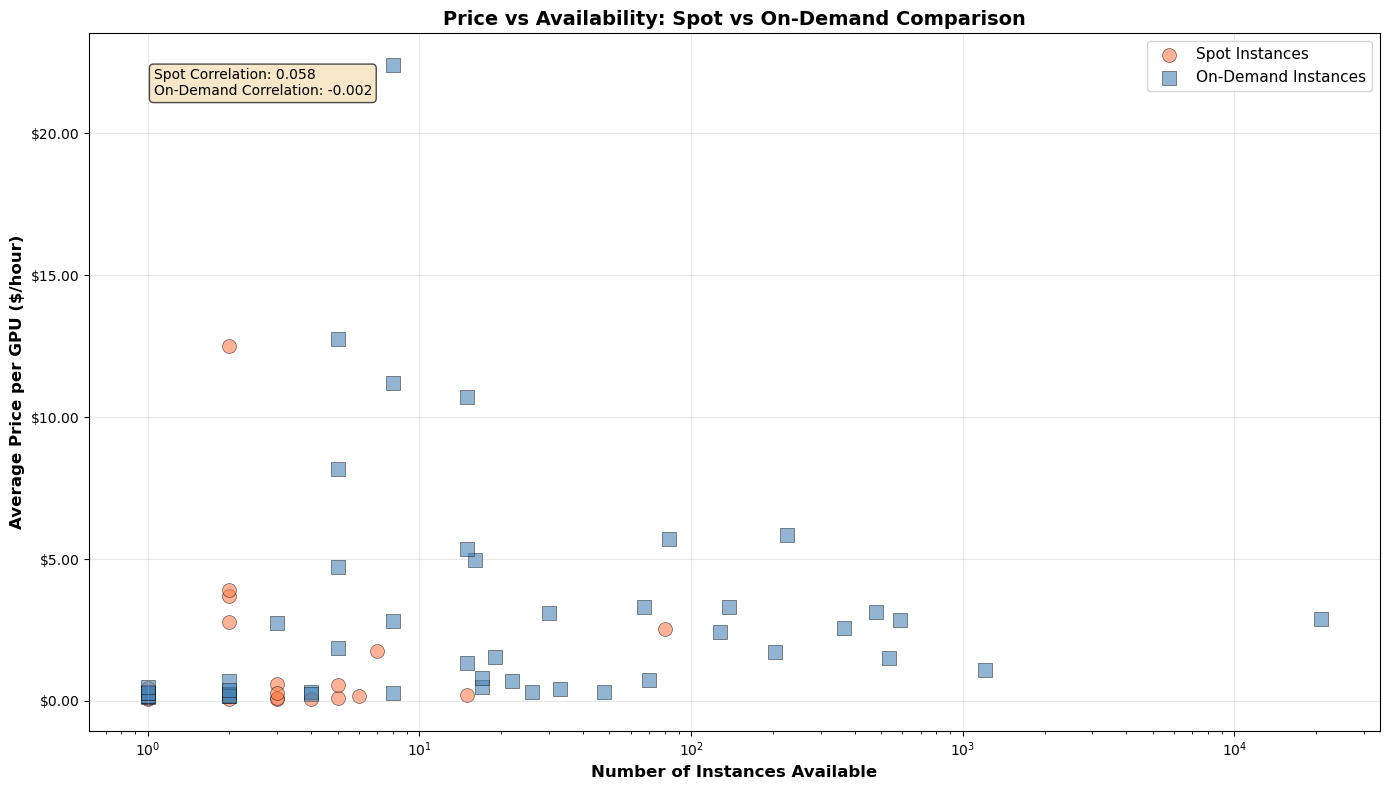

Combined price vs availability plot saved to: reports/figures/price_vs_availability_combined.png


In [14]:
# Combined Price vs Availability: Spot and On-Demand Overlay
# Create a single plot showing both spot and on-demand for comparison
fig, ax = plt.subplots(figsize=(14, 8))

if len(spot_data) > 0:
    scatter1 = ax.scatter(spot_data['instance_count'], spot_data['avg_price'], 
                         s=100, alpha=0.6, color='coral', edgecolors='black', linewidth=0.5,
                         label='Spot Instances', marker='o')
    
if len(ondemand_data) > 0:
    scatter2 = ax.scatter(ondemand_data['instance_count'], ondemand_data['avg_price'], 
                         s=100, alpha=0.6, color='steelblue', edgecolors='black', linewidth=0.5,
                         label='On-Demand Instances', marker='s')

ax.set_xlabel('Number of Instances Available', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Price per GPU ($/hour)', fontsize=12, fontweight='bold')
ax.set_title('Price vs Availability: Spot vs On-Demand Comparison', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

# Add correlation info
if len(spot_data) > 1 and len(ondemand_data) > 1:
    spot_corr = spot_data['instance_count'].corr(spot_data['avg_price'])
    ondemand_corr = ondemand_data['instance_count'].corr(ondemand_data['avg_price'])
    info_text = f'Spot Correlation: {spot_corr:.3f}\nOn-Demand Correlation: {ondemand_corr:.3f}'
    ax.text(0.05, 0.95, info_text, 
           transform=ax.transAxes, fontsize=10,
           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig('reports/figures/price_vs_availability_combined.png', dpi=300, bbox_inches='tight')
plt.show()
print("Combined price vs availability plot saved to: reports/figures/price_vs_availability_combined.png")


## Visualizations


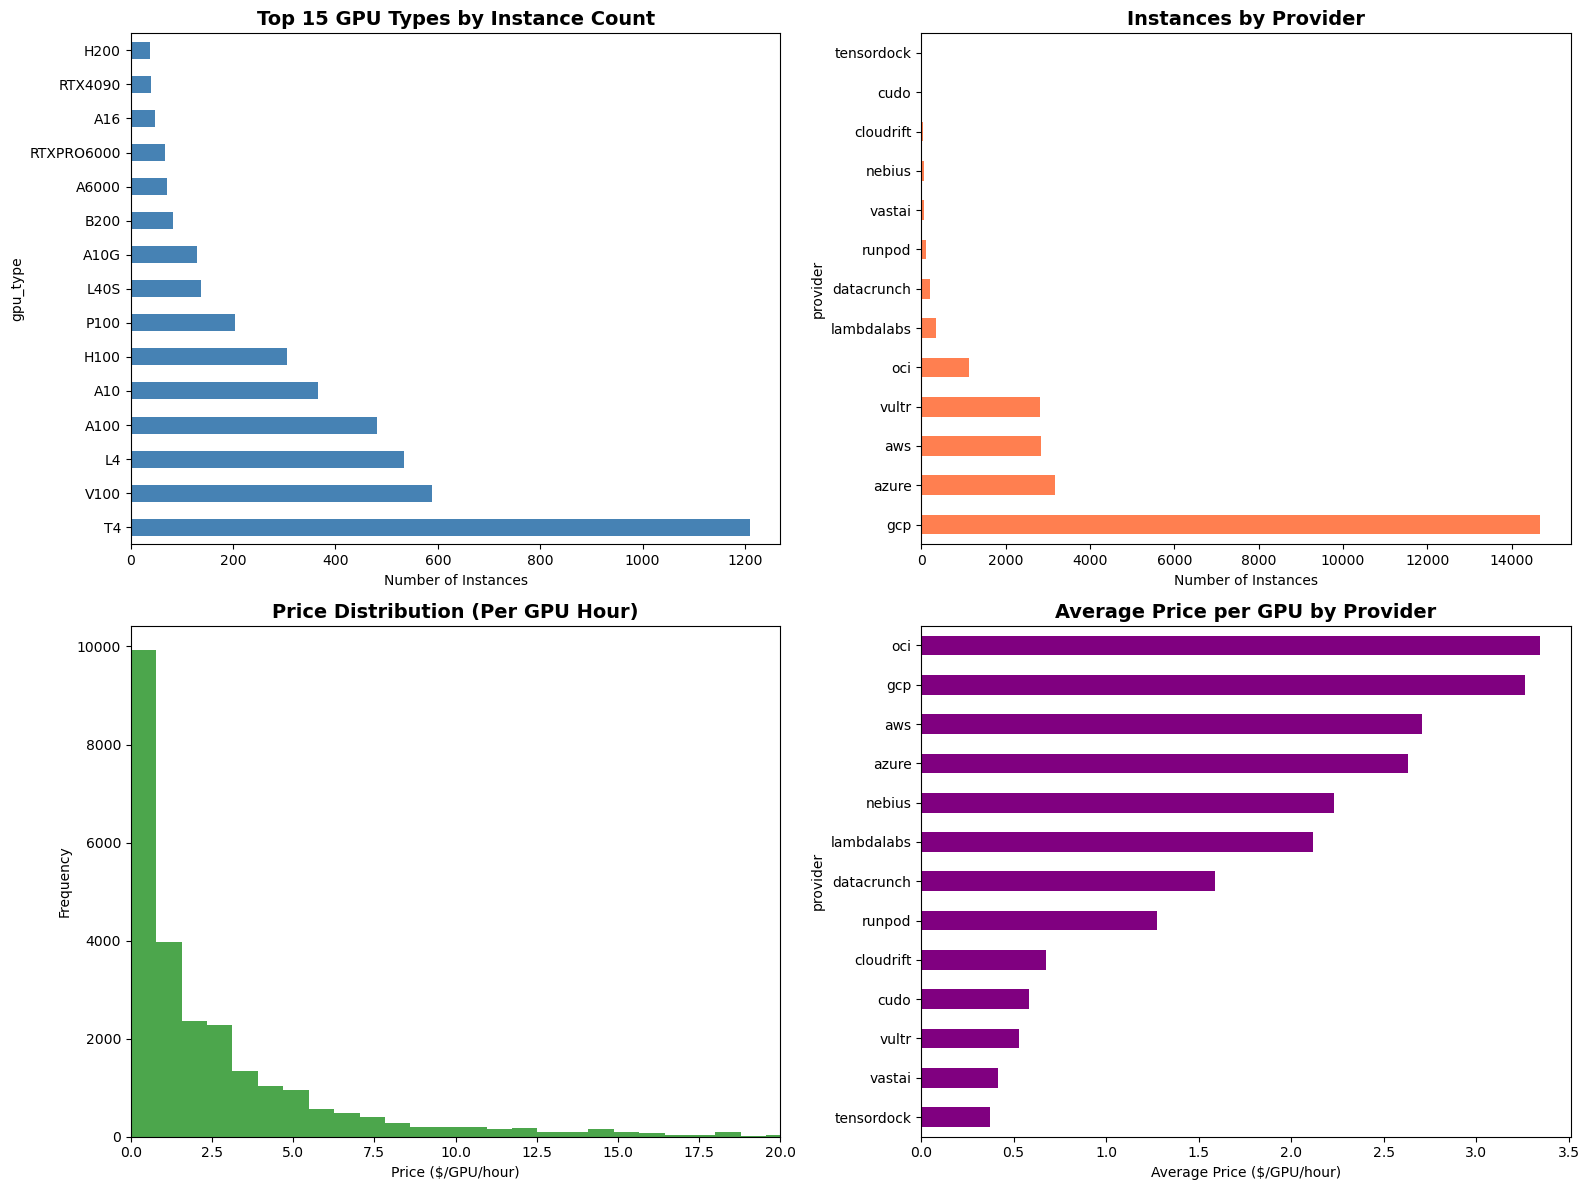

In [15]:
top_15_gpus = gpu_df.groupby('gpu_type').size().nlargest(15)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Instance count by GPU type
top_15_gpus.plot(kind='barh', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Top 15 GPU Types by Instance Count', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Instances')

# Instance count by provider
latest_df['provider'].value_counts().plot(kind='barh', ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Instances by Provider', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Instances')

# Price distribution
latest_df['price_per_gpu'].plot(kind='hist', bins=50, ax=axes[1, 0], color='green', alpha=0.7)
axes[1, 0].set_title('Price Distribution (Per GPU Hour)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Price ($/GPU/hour)')
axes[1, 0].set_xlim(0, 20)

# Average price by provider
latest_df.groupby('provider')['price_per_gpu'].mean().sort_values().plot(kind='barh', ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Average Price per GPU by Provider', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Average Price ($/GPU/hour)')

plt.tight_layout()
plt.savefig('reports/figures/summary_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


## Time Series Analysis - GPU Price Trends


Number of snapshots: 32


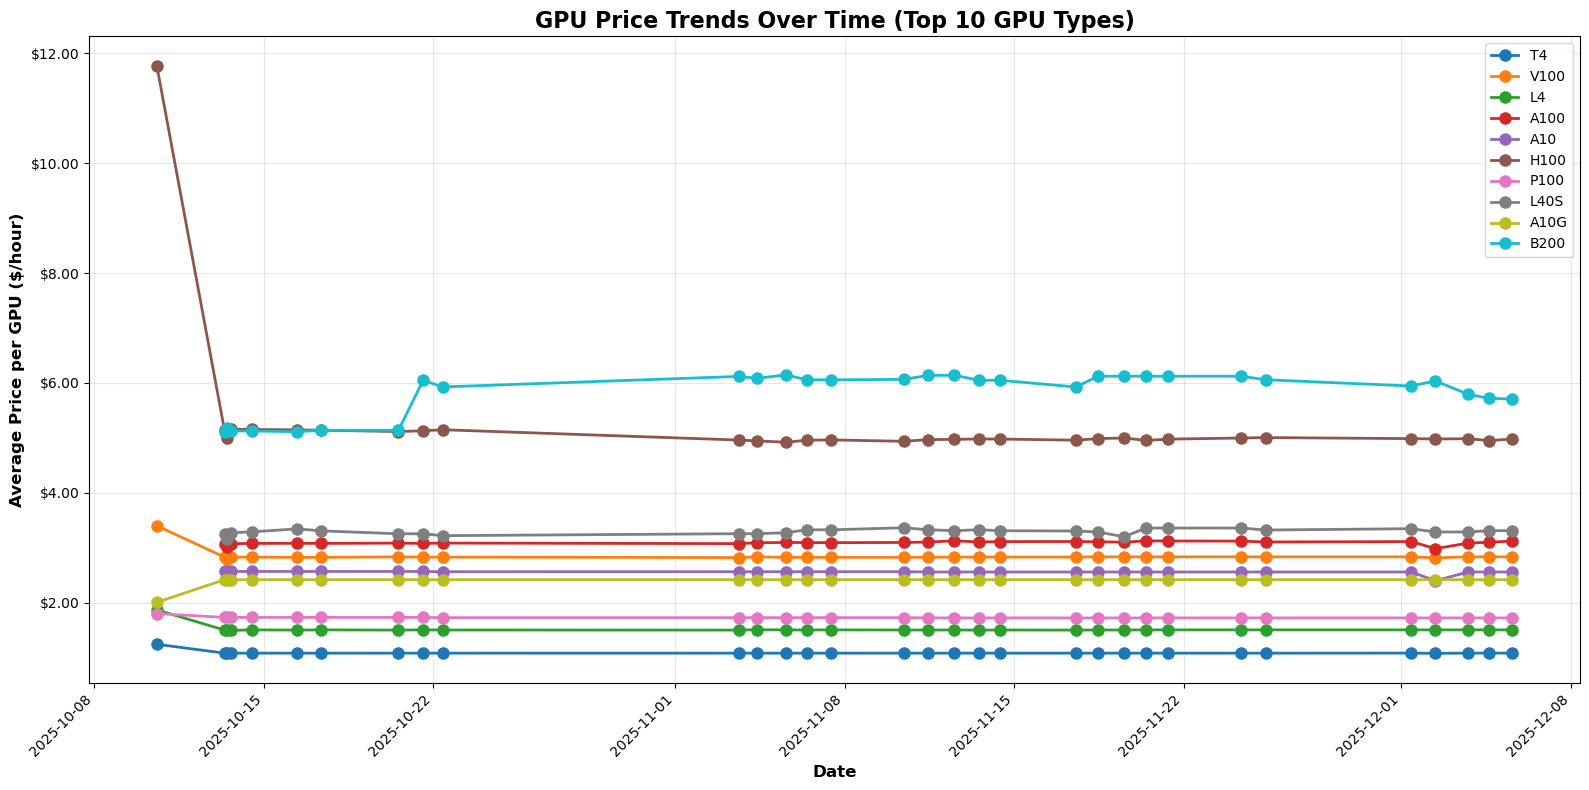


Time series plot saved to: reports/figures/price_trends_time_series.png


In [16]:
# Check if we have multiple snapshots
num_snapshots = df['timestamp'].nunique()
print(f"Number of snapshots: {num_snapshots}")

if num_snapshots > 1:
    # Get top 10 GPU types by instance count (excluding Unknown)
    top_gpus = gpu_df.groupby('gpu_type').size().nlargest(10).index.tolist()
    
    # Filter data for top GPUs
    ts_df = df[df['gpu_type'].isin(top_gpus)].copy()
    
    # Calculate average price per GPU for each timestamp and GPU type
    time_series = ts_df.groupby(['timestamp', 'gpu_type'])['price_per_gpu'].mean().reset_index()
    
    # Create time series plot
    fig, ax = plt.subplots(figsize=(16, 8))
    
    for gpu in top_gpus:
        gpu_data = time_series[time_series['gpu_type'] == gpu]
        ax.plot(gpu_data['timestamp'], gpu_data['price_per_gpu'], 
                marker='o', linewidth=2, markersize=8, label=gpu)
    
    ax.set_title('GPU Price Trends Over Time (Top 10 GPU Types)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Price per GPU ($/hour)', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Format y-axis as currency
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('reports/figures/price_trends_time_series.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nTime series plot saved to: reports/figures/price_trends_time_series.png")
else:
    print("Only one snapshot available. Need multiple snapshots for time series analysis.")
    print("Run collection twice daily to build historical data.")


## Price Change Analysis (if multiple snapshots)


In [17]:
if num_snapshots > 1:
    # Compare first and last snapshot
    first_timestamp = df['timestamp'].min()
    last_timestamp = df['timestamp'].max()
    
    first_df = df[df['timestamp'] == first_timestamp].copy()
    last_df = df[df['timestamp'] == last_timestamp].copy()
    
    # Calculate average price per GPU type
    first_prices = first_df.groupby('gpu_type')['price_per_gpu'].mean()
    last_prices = last_df.groupby('gpu_type')['price_per_gpu'].mean()
    
    # Find common GPU types
    common_gpus = set(first_prices.index) & set(last_prices.index)
    
    # Calculate price changes
    price_changes = []
    for gpu in common_gpus:
        if gpu != 'Unknown':
            first_price = first_prices[gpu]
            last_price = last_prices[gpu]
            change = last_price - first_price
            pct_change = (change / first_price) * 100 if first_price > 0 else 0
            price_changes.append({
                'GPU Type': gpu,
                'First Price': first_price,
                'Last Price': last_price,
                'Change ($)': change,
                'Change (%)': pct_change
            })
    
    changes_df = pd.DataFrame(price_changes).sort_values('Change (%)', ascending=False)
    
    print(f"\nPRICE CHANGES: {first_timestamp.date()} to {last_timestamp.date()}")
    print("=" * 80)
    print(f"\nBiggest Increases:")
    print(changes_df.head(10).to_string(index=False))
    
    print(f"\n\nBiggest Decreases:")
    print(changes_df.tail(10).to_string(index=False))
else:
    print("Need multiple snapshots for price change analysis.")



PRICE CHANGES: 2025-10-10 to 2025-12-05

Biggest Increases:
GPU Type  First Price  Last Price  Change ($)  Change (%)
    A10G     2.011050    2.422749    0.411699   20.471851
    P100     1.806458    1.727749   -0.078709   -4.357103
      T4     1.248284    1.087648   -0.160636  -12.868543
    V100     3.403750    2.838720   -0.565030  -16.600209
      L4     1.874167    1.510095   -0.364072  -19.425804
    H100    11.770000    4.981517   -6.788483  -57.676148


Biggest Decreases:
GPU Type  First Price  Last Price  Change ($)  Change (%)
    A10G     2.011050    2.422749    0.411699   20.471851
    P100     1.806458    1.727749   -0.078709   -4.357103
      T4     1.248284    1.087648   -0.160636  -12.868543
    V100     3.403750    2.838720   -0.565030  -16.600209
      L4     1.874167    1.510095   -0.364072  -19.425804
    H100    11.770000    4.981517   -6.788483  -57.676148


## Individual GPU Type Time Series


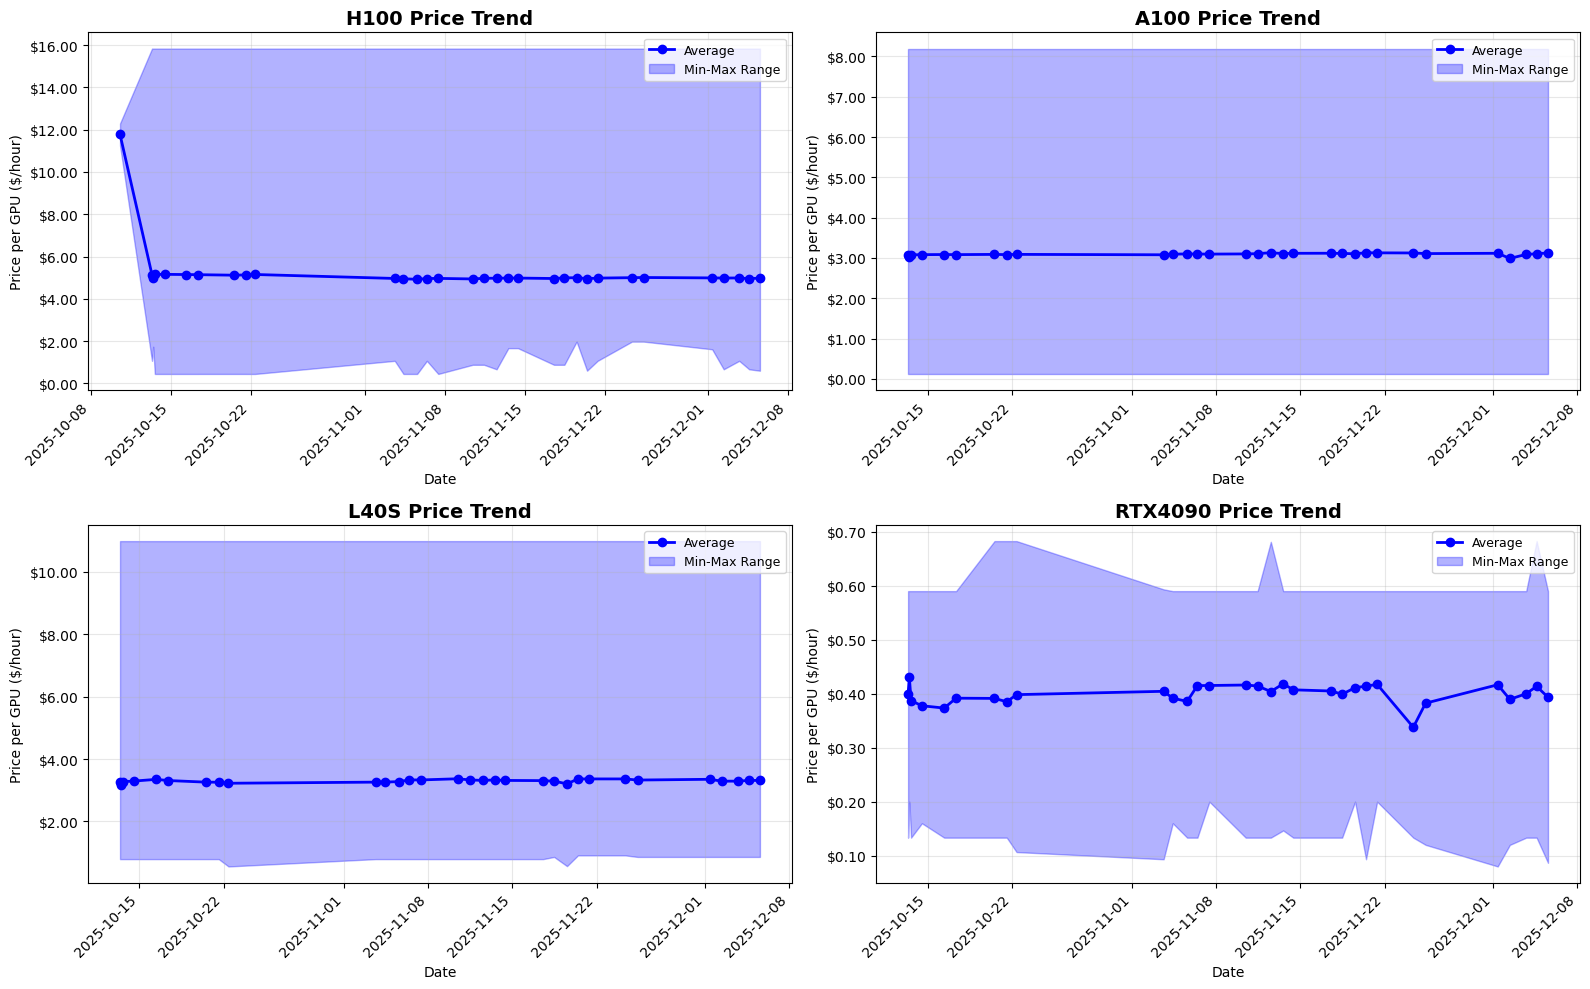

Individual GPU trends saved to: reports/figures/individual_gpu_trends.png


In [18]:
if num_snapshots > 1:
    # Create individual plots for specific GPU types
    gpu_types_to_plot = ['H100', 'A100', 'L40S', 'RTX4090']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, gpu_type in enumerate(gpu_types_to_plot):
        if gpu_type in df['gpu_type'].values:
            gpu_ts = df[df['gpu_type'] == gpu_type].groupby('timestamp')['price_per_gpu'].agg(['mean', 'min', 'max']).reset_index()
            
            ax = axes[idx]
            ax.plot(gpu_ts['timestamp'], gpu_ts['mean'], marker='o', linewidth=2, label='Average', color='blue')
            ax.fill_between(gpu_ts['timestamp'], gpu_ts['min'], gpu_ts['max'], alpha=0.3, color='blue', label='Min-Max Range')
            
            ax.set_title(f'{gpu_type} Price Trend', fontsize=14, fontweight='bold')
            ax.set_xlabel('Date', fontsize=10)
            ax.set_ylabel('Price per GPU ($/hour)', fontsize=10)
            ax.legend(loc='best', fontsize=9)
            ax.grid(True, alpha=0.3)
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        else:
            axes[idx].text(0.5, 0.5, f'{gpu_type}\nNo data available', 
                          ha='center', va='center', fontsize=12)
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('reports/figures/individual_gpu_trends.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Individual GPU trends saved to: reports/figures/individual_gpu_trends.png")
else:
    print("Need multiple snapshots for individual GPU time series analysis.")


## Instance Count Time Series by GPU Type


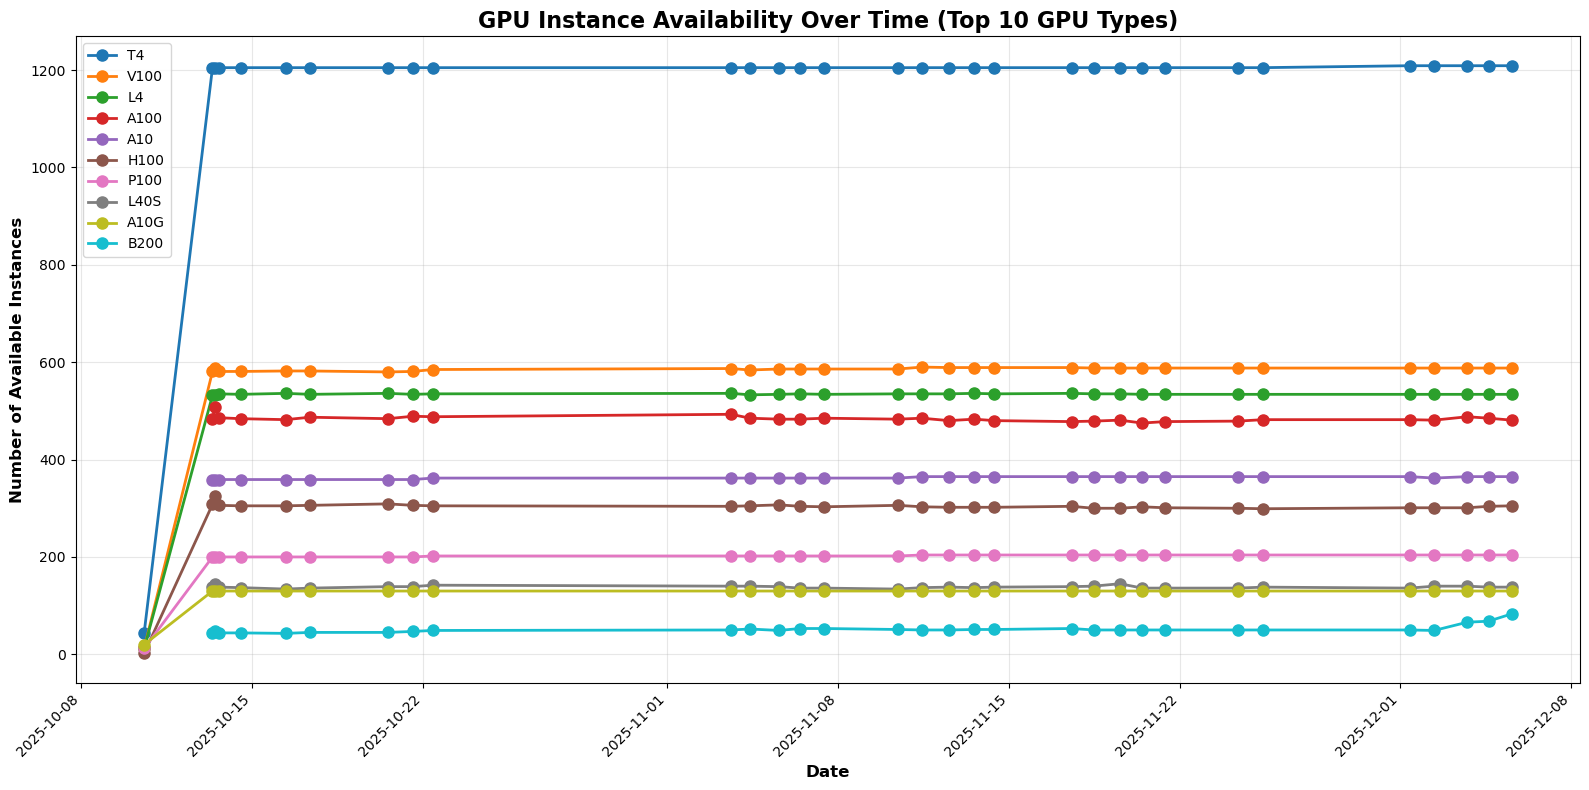


Instance count time series saved to: reports/figures/instance_count_time_series.png

INSTANCE COUNT CHANGES
T4             :    44 →  1209 instances (+1165, +2647.7%)
V100           :    12 →   588 instances ( +576, +4800.0%)
L4             :    12 →   534 instances ( +522, +4350.0%)
A100           :   484 →   481 instances (   -3,   -0.6%)
A10            :   359 →   365 instances (   +6,   +1.7%)


In [19]:
if num_snapshots > 1:
    # Get top 10 GPU types by average instance count (excluding Unknown)
    avg_counts = gpu_df.groupby('gpu_type').size()
    top_gpus_by_count = avg_counts.nlargest(10).index.tolist()
    
    # Count instances for each GPU type at each timestamp
    instance_counts = df[df['gpu_type'].isin(top_gpus_by_count)].groupby(['timestamp', 'gpu_type']).size().reset_index(name='count')
    
    # Create time series plot for instance counts
    fig, ax = plt.subplots(figsize=(16, 8))
    
    for gpu in top_gpus_by_count:
        gpu_data = instance_counts[instance_counts['gpu_type'] == gpu]
        ax.plot(gpu_data['timestamp'], gpu_data['count'], 
                marker='o', linewidth=2, markersize=8, label=gpu)
    
    ax.set_title('GPU Instance Availability Over Time (Top 10 GPU Types)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Available Instances', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('reports/figures/instance_count_time_series.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nInstance count time series saved to: reports/figures/instance_count_time_series.png")
    
    # Show summary statistics
    print("\nINSTANCE COUNT CHANGES")
    print("=" * 80)
    for gpu in top_gpus_by_count[:5]:
        gpu_data = instance_counts[instance_counts['gpu_type'] == gpu]
        if len(gpu_data) > 0:
            first_count = gpu_data.iloc[0]['count']
            last_count = gpu_data.iloc[-1]['count']
            change = last_count - first_count
            pct_change = (change / first_count * 100) if first_count > 0 else 0
            print(f"{gpu:15s}: {first_count:5d} → {last_count:5d} instances ({change:+5d}, {pct_change:+6.1f}%)")
else:
    print("Need multiple snapshots for instance count time series analysis.")


## Provider Instance Count Over Time


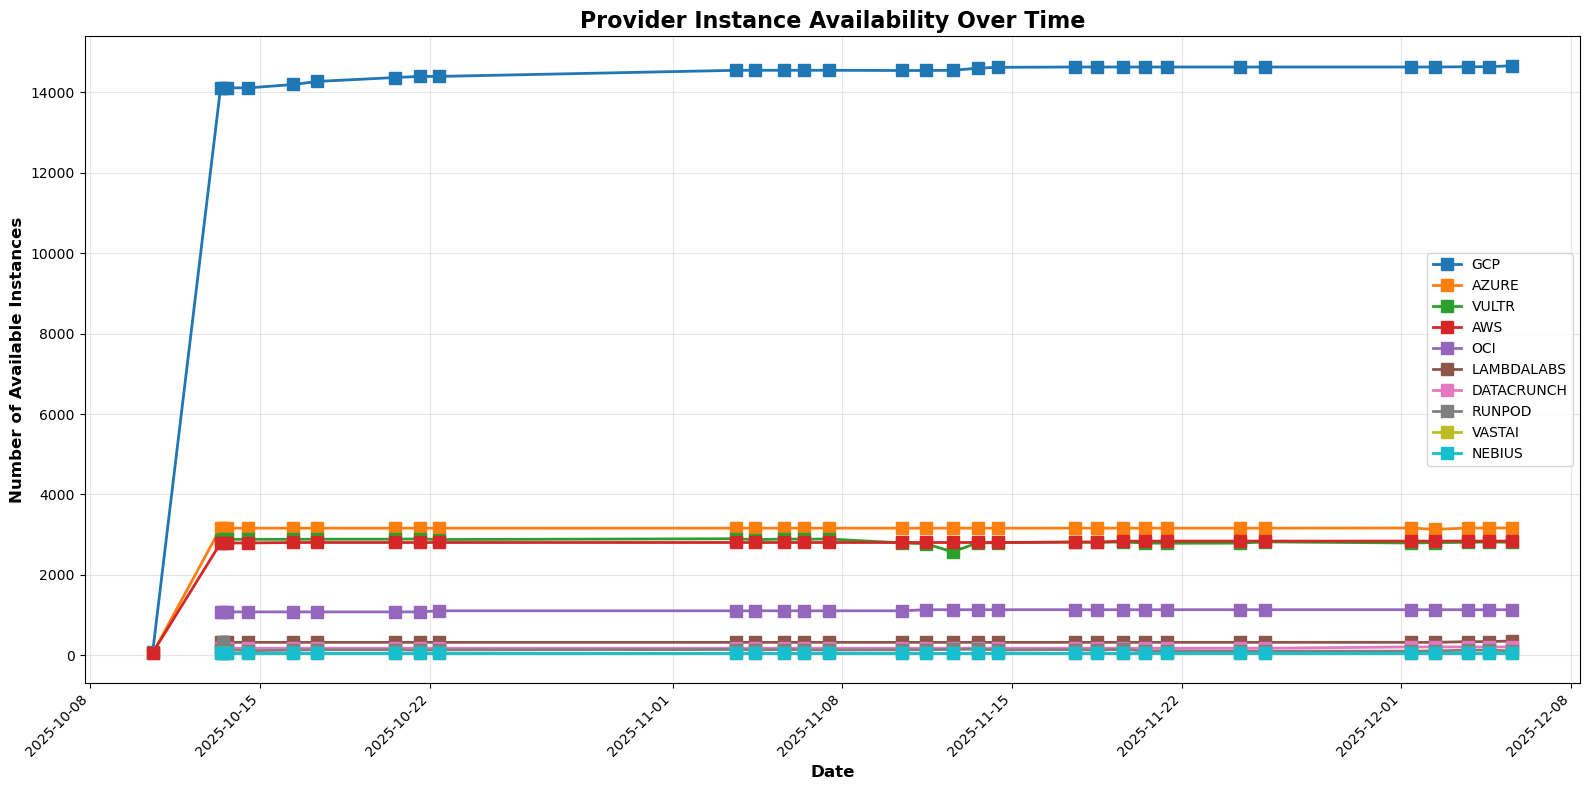


Provider instance count time series saved to: reports/figures/provider_instance_time_series.png


In [20]:
if num_snapshots > 1:
    # Count instances by provider over time
    provider_counts = df.groupby(['timestamp', 'provider']).size().reset_index(name='count')
    
    # Get top providers by average instance count
    avg_provider_counts = df.groupby('provider').size()
    top_providers = avg_provider_counts.nlargest(10).index.tolist()
    
    # Create time series plot for provider instance counts
    fig, ax = plt.subplots(figsize=(16, 8))
    
    for provider in top_providers:
        provider_data = provider_counts[provider_counts['provider'] == provider]
        ax.plot(provider_data['timestamp'], provider_data['count'], 
                marker='s', linewidth=2, markersize=8, label=provider.upper())
    
    ax.set_title('Provider Instance Availability Over Time', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Available Instances', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('reports/figures/provider_instance_time_series.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nProvider instance count time series saved to: reports/figures/provider_instance_time_series.png")
else:
    print("Need multiple snapshots for provider instance count time series.")


## Combined Analysis - Instance Count vs Price


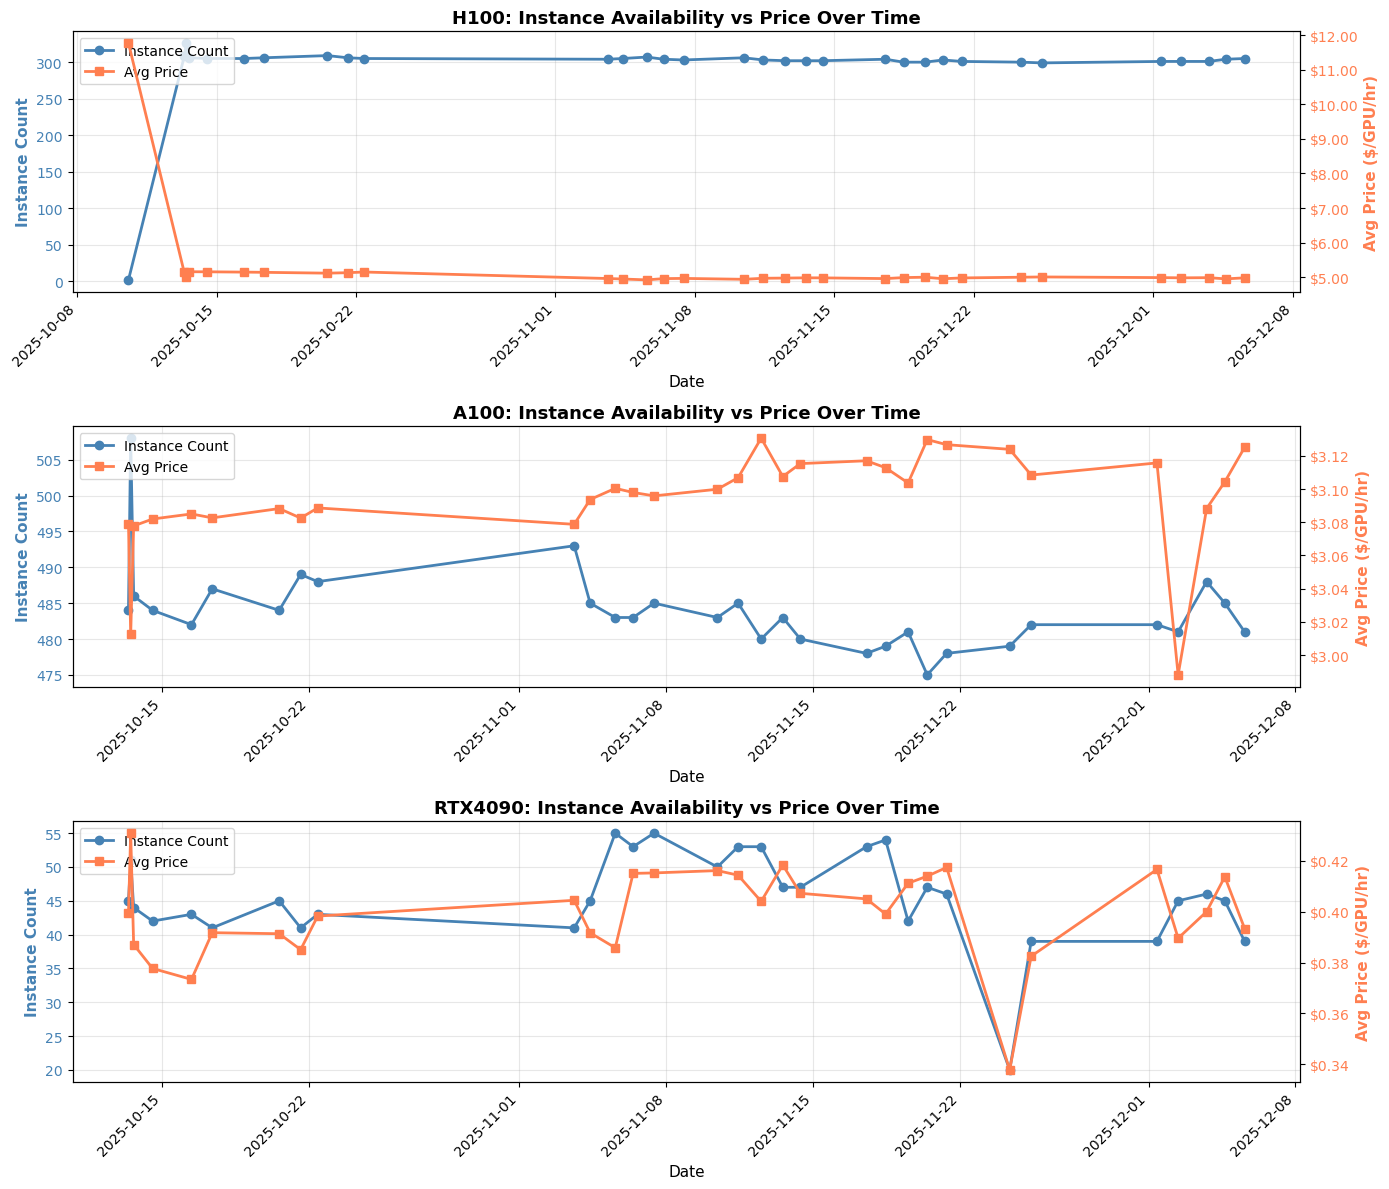

Instance vs price analysis saved to: reports/figures/instance_vs_price_analysis.png


In [21]:
if num_snapshots > 1:
    # Analyze relationship between instance count and price for specific GPUs
    gpus_to_analyze = ['H100', 'A100', 'RTX4090']
    
    fig, axes = plt.subplots(len(gpus_to_analyze), 1, figsize=(14, 12))
    if len(gpus_to_analyze) == 1:
        axes = [axes]
    
    for idx, gpu in enumerate(gpus_to_analyze):
        if gpu in df['gpu_type'].values:
            # Get price and instance count data
            gpu_data = df[df['gpu_type'] == gpu].groupby('timestamp').agg({
                'price_per_gpu': 'mean',
                'instance_type': 'count'
            }).reset_index()
            gpu_data.columns = ['timestamp', 'avg_price', 'instance_count']
            
            # Create dual-axis plot
            ax1 = axes[idx]
            ax2 = ax1.twinx()
            
            # Plot instance count
            line1 = ax1.plot(gpu_data['timestamp'], gpu_data['instance_count'], 
                            marker='o', linewidth=2, color='steelblue', label='Instance Count')
            ax1.set_ylabel('Instance Count', fontsize=11, fontweight='bold', color='steelblue')
            ax1.tick_params(axis='y', labelcolor='steelblue')
            
            # Plot average price
            line2 = ax2.plot(gpu_data['timestamp'], gpu_data['avg_price'], 
                            marker='s', linewidth=2, color='coral', label='Avg Price')
            ax2.set_ylabel('Avg Price ($/GPU/hr)', fontsize=11, fontweight='bold', color='coral')
            ax2.tick_params(axis='y', labelcolor='coral')
            ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.2f}'))
            
            # Title and labels
            ax1.set_title(f'{gpu}: Instance Availability vs Price Over Time', fontsize=13, fontweight='bold')
            ax1.set_xlabel('Date', fontsize=11)
            ax1.grid(True, alpha=0.3)
            
            # Combined legend
            lines = line1 + line2
            labels = [l.get_label() for l in lines]
            ax1.legend(lines, labels, loc='upper left', fontsize=10)
            
            plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
        else:
            axes[idx].text(0.5, 0.5, f'{gpu}\nNo data available', 
                          ha='center', va='center', fontsize=12)
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('reports/figures/instance_vs_price_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Instance vs price analysis saved to: reports/figures/instance_vs_price_analysis.png")
else:
    print("Need multiple snapshots for combined instance vs price analysis.")


In [22]:
# Close connection
conn.close()
print("Analysis complete!")


Analysis complete!
